<h1 align="center"><font size="5">Digit recognition of seven segment display</font></h1>

In [1]:
# import the required packages
import cv2
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

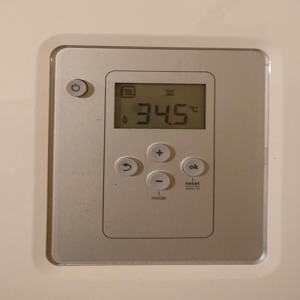

In [2]:
# Display the image 
img = Image.open("images/seven_seg.jpg")
img.resize((300,300))

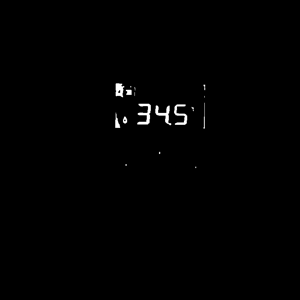

In [3]:
# load the image 
img = cv2.imread("images/seven_seg.jpg")
# convert it to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Smooth the image
blur = cv2.GaussianBlur(gray, (7,7), 0)
# Separate the dark digits in display from the remaining image
thresh = cv2.threshold(blur, 55, 255, cv2.THRESH_BINARY_INV)[1]

# erosion and morphological operations are done to focus only on digits
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
dil = cv2.erode(thresh, np.ones((2, 2), np.uint8), iterations=1)

# display the separated digits from the image
Image.fromarray(dil).resize((300,300))

In [4]:
# find the contour for each digit in the display
_, cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:3]

940.5
769.5
758.5


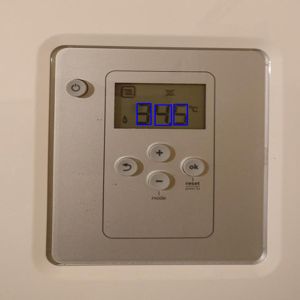

In [5]:
# Draw a blue rectangle over each digit localized in the image and save its coordinates
# first create a copy of the original image
clone = img.copy()
roi = []
rects = []
for cnt in cnts:
    print(cv2.contourArea(cnt))
    rect = cv2.boundingRect(cnt)
    x,y, w,h = rect
    cv2.rectangle(clone, (x,y), (x+w,y+h), (255,0,0), 2)
    roi.append(cnt)
    rects.append(rect)
    
# convert the color from bgr to rgb 
clone = cv2.cvtColor(clone, cv2.COLOR_BGR2RGB)  
# display the image with rectangles drawn on each digit
Image.fromarray(clone).resize((300,300))

In [6]:
# save each digit as a numpy array (img) in a list
digits = []
#unique = []

for rect in rects:
    x,y,w,h = rect
    digit_roi = img[y:y+h, x:x+w]
    
    digit_roi = cv2.cvtColor(digit_roi, cv2.COLOR_BGR2GRAY)

    digit_roi = cv2.threshold(digit_roi, 50, 255, cv2.THRESH_BINARY_INV)[1]
    
    digit_roi = cv2.dilate(digit_roi, np.ones((2, 2), np.uint8), iterations=1)
    digit_roi = cv2.resize(digit_roi, (200,200))
    #unique.append((np.unique(digit_roi)))
    digits.append(digit_roi)

In [7]:
# check if length of detected digits is 3
len(digits)

3

In [8]:
# define a function to preprocess the test images
def preprocess_images(img, thresh=50, img_size=(200,200)):
    img = cv2.imread(img)
    img = cv2.resize(img, img_size, cv2.INTER_CUBIC) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
    img = cv2.medianBlur(img, 3)
    img = cv2.dilate(img, np.ones((1,1), np.uint8), iterations=1)
    
    return img

## SVM Model

The model is trained on singular sample for each digit from 0-9. After testing various classification models, I opted for SVM as it gave better results for large number of image features which are basically values of a binary image (0,255). 

In [9]:
image_directory = "images/train_digits/"
train_data = []

#get training data
for filename in sorted(os.listdir(image_directory)):
    img = image_directory + filename
    img = preprocess_images(img)
    train_data.append(img)

train_data = np.asarray(train_data, dtype=np.float32)
print(train_data.shape)
train_data = np.reshape(train_data,(10,-1))
print(train_data.shape)

#mark training label
train_label = np.array([0,1,2,3,4,5,6,7,8,9], dtype=int)

(10, 200, 200)
(10, 40000)


In [10]:
#create SVM model with tuned parameters 
model = cv2.ml.SVM_create()
model.setType(cv2.ml.SVM_C_SVC)
model.setKernel(cv2.ml.SVM_LINEAR)
model.setTermCriteria((cv2.TERM_CRITERIA_COUNT, 100, 1.e-06))
model.train(train_data, cv2.ml.ROW_SAMPLE, train_label)

#save model
model.save("model.xml")

In [23]:
#make predictions on digits extracted from thermostat display to display the number
test_data = []
pred = []
for i in range(3):
    img = digits[i]
    #test_data.append(img) 
    test_data = np.asarray(img, dtype=np.float32)
    test_data = np.reshape(test_data, (1,-1))

    _, result = model.predict(test_data)
    pred.append(result)
    
print("prediction result : ")
print("{}{}.{}°C".format(int(pred[0][0][0]), int(pred[1][0][0]), int(pred[2][0][0])))

prediction result : 
34.5°C


In [24]:
#lets check the model on digits cropped from different images
test_data = []
test_dir = "images/test_digits/"
test_images = os.listdir(test_dir)

for img in test_images:
    img = test_dir + img
    img = preprocess_images(img)
    test_data.append(img) 
    
test_array = np.asarray(test_data, dtype=np.float32)
test_array = np.reshape(test_array, (len(test_data),-1))

In [25]:
# actual values of digits
true_val = [0,0,1,1,1,2,2,3,3,4,4,7,1,2,7,8]

In [26]:
_, y_val = model.predict(test_array)
#print("prediction result")
#print(y_val)

for i in range(len(y_val)):
    img_paths = test_dir + test_images[i]
    img = cv2.imread(img_paths)

In [27]:
len(test_data)

16

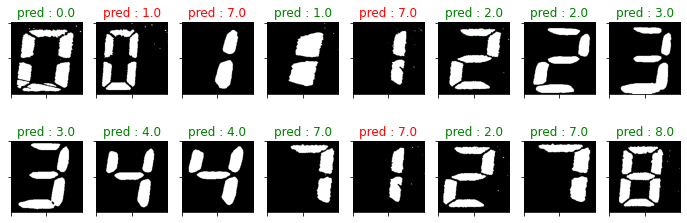

In [28]:
# display the results. Green color for correct predictions and red for wrong one
k = 0
fig, axes = plt.subplots(figsize=(12,4),nrows=2,ncols=8)
for i in range(2):
    for j in range(8):
        ax = axes[int(str(i))][int(str(j))]
        ax.imshow(test_data[k], cmap='gray')
        ax.set_xticklabels('')
        ax.set_yticklabels('')
        color = 'g' if y_val[k] == true_val[k] else 'r'
        ax.set_title("pred : {}".format(y_val[k][0]), color=color)
        k = k + 1

# CONCLUSION :

- This project is simple and good enough for beginners but not robust to handle varied image in differnt lighting conditions
- The trained SVM although performs better than others I tested but fails to distinguish uniquely between **1** and **7**

### Thanks for reading